# Example Plots

In [126]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
import ee
import h5py
import math
import datetime
import requests
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime 
from datetime import timedelta
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [127]:
# out_path_csv = '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/GLD1_all_lakes.csv'
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fix_gooddata.csv'
# out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_all_returned_lakes.csv'
df = pd.read_csv(out_path_csv)
df_lakes = df.copy()

In [141]:
#####################################################################
def plotIS2(fn, ax=None, xlm=[None, None], ylm=[None,None], cmap=cmc.lapaz_r, name='ICESat-2 data', plot_num=1):
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+1.5*lk.max_depth
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    dfd = dfd[(dfd.xatc >= xlm[0]) & (dfd.xatc <= xlm[1]) & (dfd.h_fit_bed >= ylm[0])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd.xatc -= x_off
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed.copy()
    bed[~isdepth] = np.nan
    bed[dfd.conf < 0.5] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    surf_only = surf[~np.isnan(surf)]
    bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
    xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
    xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
    
    # make the figure
    if not ax:
        fig, ax = plt.subplots(figsize=[8,5])

    if plot_num > 1:
        df['is_afterpulse']= df.prob_afterpulse > np.random.uniform(0,1,len(df))
        df = df[~df.is_afterpulse].copy()
    if (plot_num > 4) & (plot_num < 9):
        sf = lk.surface_elevation
        width = 0.35
        xmin = np.min(xatc_surf)
        xmax = np.max(xatc_surf)
        is_water = (df.xatc>xmin) & (df.xatc<xmax) & (df.h>(sf-width)) & (df.h<(sf+width))
        df = df[~is_water].copy()
    if (plot_num > 2) & (plot_num < 9):
        ax.scatter(df.xatc, df.h, s=1, c=df.snr, cmap=cmap)
    else:
        ax.scatter(df.xatc, df.h, s=1, c='k')

    if (plot_num == 4) | (plot_num == 9):
        ax.plot(dfd.xatc, surf, color='C0', lw=3)
        
    if plot_num == 6:
        ax.plot(dfd.xatc, dfd.h_fit_bed, color='r', lw=3)

    if plot_num == 7:
        ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=dfd.conf[isdepth]*40, c=[(1,1-r,1-r) for r in dfd.conf[isdepth]**2])

    if plot_num > 7:
        ax.plot(dfd.xatc, bed, color='r', lw=3)

    # add the length of surface
    arr_y = lk.surface_elevation+lk.max_depth*0.25
    x_start = np.min(xatc_surf)
    x_end = np.max(xatc_surf)
    x_mid = (x_end + x_start) / 2
    len_surf_m = np.floor((x_end-x_start)/100)*100
    len_surf_km = len_surf_m/1000
    arr_x1 = x_mid - len_surf_m / 2
    arr_x2 = x_mid + len_surf_m / 2
    if (plot_num == 4) | (plot_num == 9):
        ax.annotate('', xy=(arr_x1, arr_y), xytext=(arr_x2, arr_y),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
        ax.annotate('', xy=(arr_x2, arr_y), xytext=(arr_x1, arr_y),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
        ax.text(x_mid, arr_y, '%.1f km' % len_surf_km, fontsize=12, ha='center', va='bottom', color='C0', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

    # add the max depth
    y_low = np.min(bed_only)
    y_up = lk.surface_elevation
    arr_x = xatc_bed[np.argmin(bed_only)]
    arr_x = xlm[0] + 0.05* (xlm[1] - xlm[0])
    y_len = y_up - y_low
    y_mid = (y_up + y_low) / 2
    arr_len = y_len
    arr_y1 = y_mid + arr_len / 2
    arr_y2 = y_mid - arr_len / 2
    ref_index = 1.33
    dep_round = np.round(y_len / ref_index, 1)
    if plot_num > 7:
        ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
        ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
        ax.text(arr_x, y_mid, '%.1f m' % dep_round, fontsize=12, ha='right', va='center', color='r', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)

    # # add the title
    # datestr = datetime.strftime(datetime.strptime(lk.date_time[:10],'%Y-%m-%d'), '%d %B %Y')
    # sheet = lk.ice_sheet
    # region = lk.polygon_filename.split('_')[-1].replace('.geojson', '')
    # if sheet == 'AIS':
    #     region = region + ' (%s)' % lk.polygon_filename.split('_')[-2]
    # latstr = lk.lat_str[:-1] + '°' + lk.lat_str[-1]
    # lonstr = lk.lon_str[:-1] + '°' + lk.lon_str[-1]
    # description = '%s\n%s - %s\n(%s, %s)' % (datestr, sheet, region, latstr, lonstr)

    # ax.text(0.5, 0.87, description, fontsize=12, ha='center', va='top', transform=ax.transAxes,
    #        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), zorder=3000)
    # ax.text(0.5, 0.9, '%s' % name, fontsize=18, ha='center', va='bottom', transform=ax.transAxes,
    #        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), fontweight='bold')

    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    ax.axis('off')

In [142]:
base = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/'

test = {
    'name': 'test',
    'fn': base + 'lake_09593649_GrIS_2020_simplified_GRE_2000_SW_ATL03_20200713115804_02770803_006_01_gt2l_0025.h5',
    'xlm': [None, None],
    'ylm': [None, None],
}

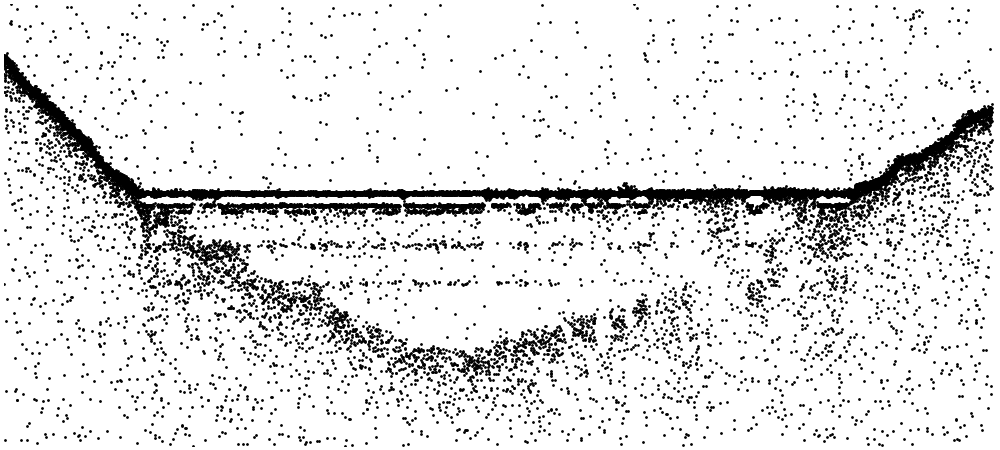

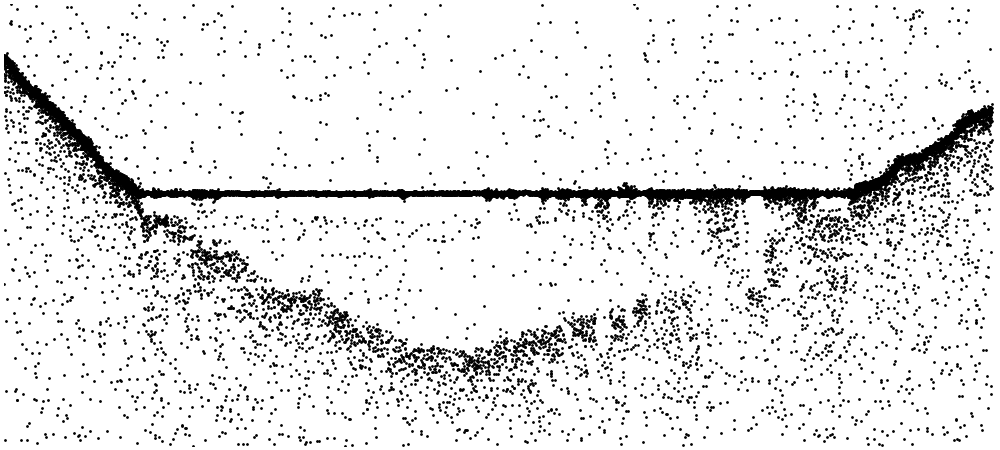

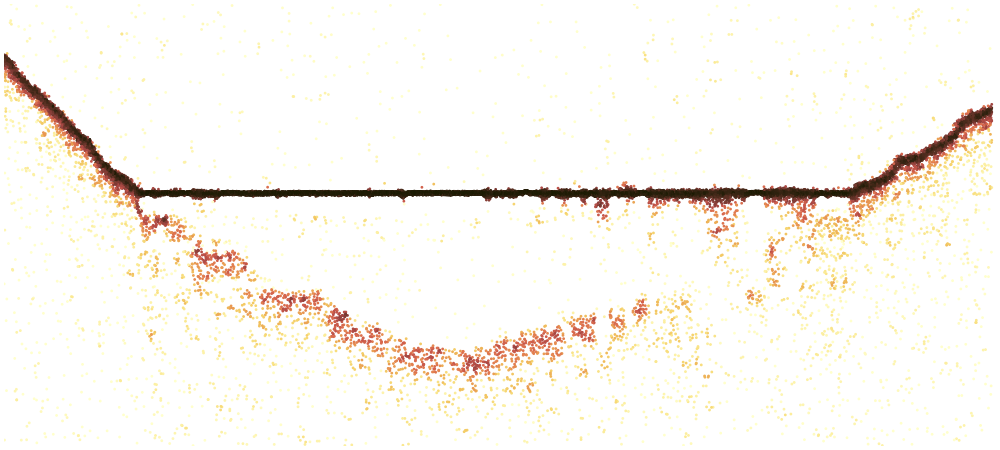

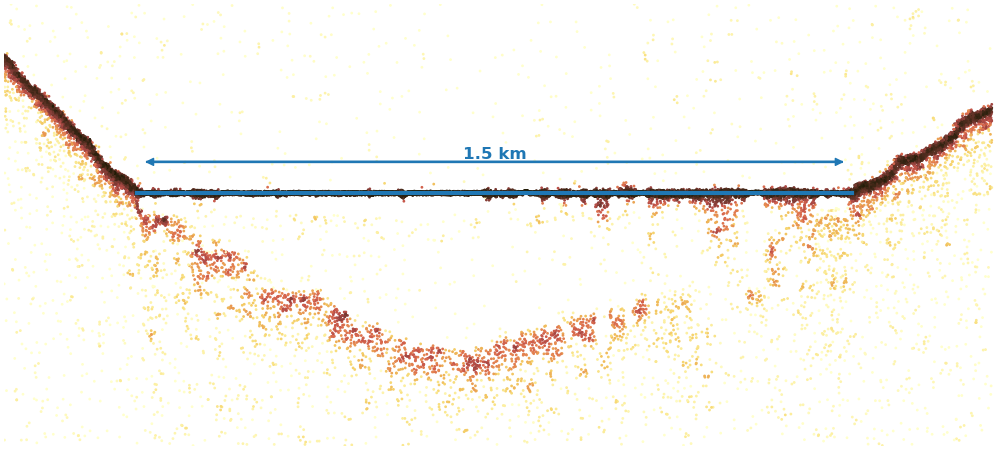

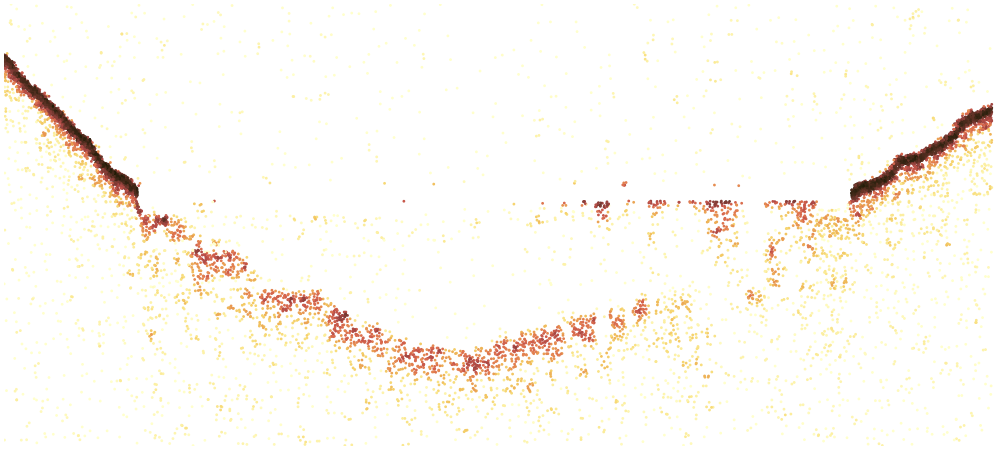

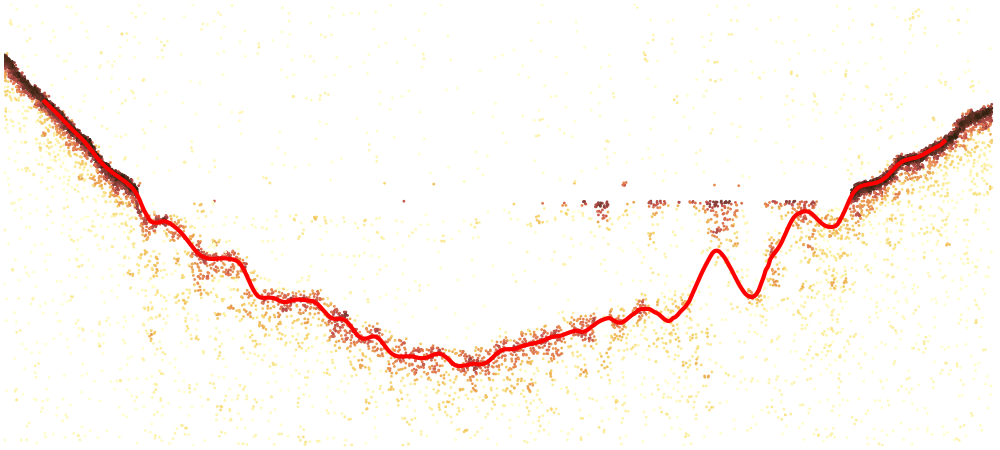

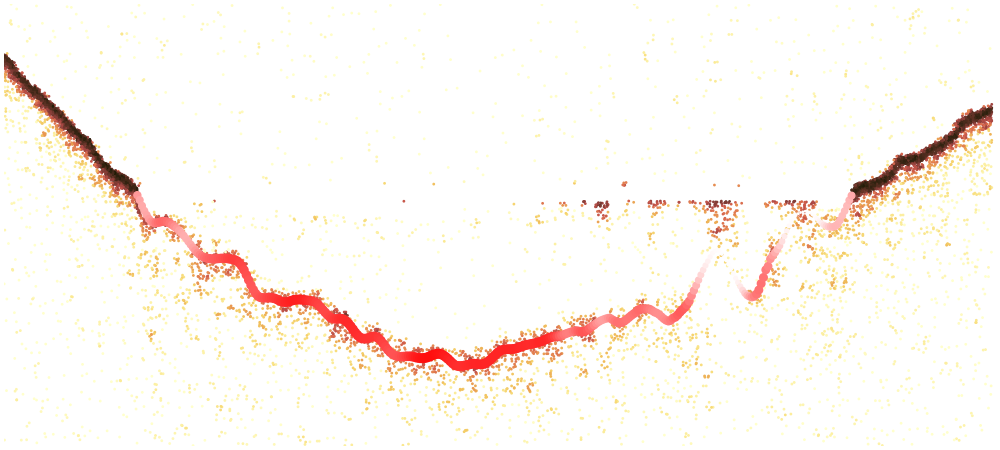

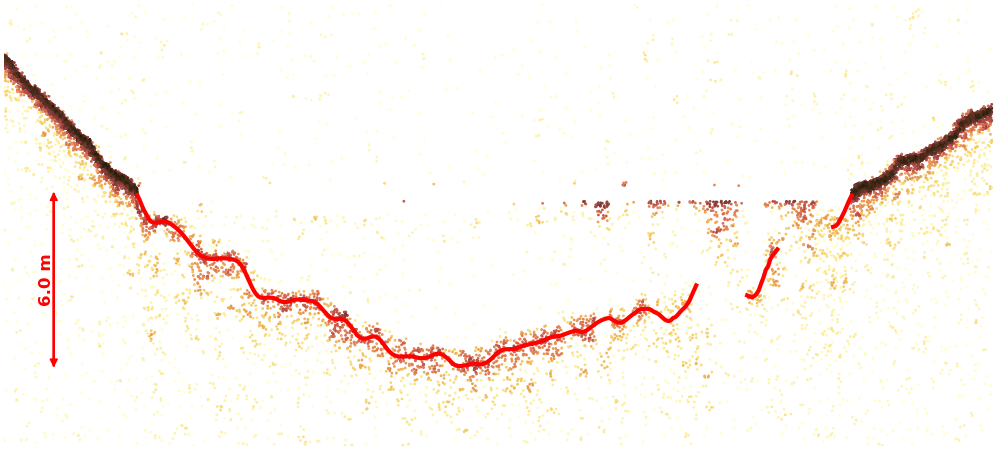

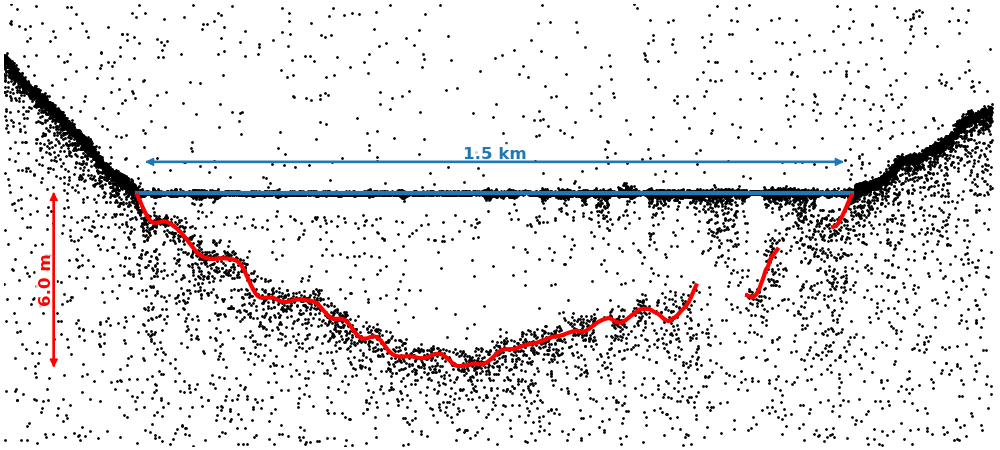

In [143]:
plt.close('all')

toplot = test
for i in range(9):
    fig, ax = plt.subplots(figsize=[10,4.5])
    plotIS2(**toplot, ax=ax, cmap=cmc.lajolla, plot_num=i+1)
    fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.4)
    fig.savefig('plots/surrf_explainer_%02i.jpg' % (i+1), dpi=600)

In [ ]:
fig = plt.figure(figsize=[32,16], dpi=30)
gs = fig.add_gridspec(6, 18)
axs = []
axs.append(fig.add_subplot(gs[1:5, 3:6])) # greenland
axs.append(fig.add_subplot(gs[1:5, 9:15])) # antarctica
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[0, j]))
    axs.append(fig.add_subplot(gs[0, j+1:j+3]))
for i in range(1,5):
    for j in np.array([0, 2, 5])*3:
        axs.append(fig.add_subplot(gs[i, j]))
        axs.append(fig.add_subplot(gs[i, j+1:j+3]))
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[5, j]))
    axs.append(fig.add_subplot(gs[5, j+1:j+3]))

ax = axs[0]
gre_bound.plot(color='k', ax=ax, lw=0.5)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
ax.axis('off')

ax = axs[1]
ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0)
ant_bound.plot(color='k', ax=ax, lw=0.5)
ant_gdf_shelf.boundary.plot(color='k', ax=ax, lw=0.5)
ax.axis('off')

for ax in axs:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

fig.tight_layout(pad=0, h_pad=0, w_pad=0)

for i, ax in enumerate(axs):
    ax.text(0.5, 0.5, '%i'%i, ha='center', va='center', transform=ax.transAxes, fontsize=20)

fig.tight_layout(pad=1, h_pad=1, w_pad=1)